<img src="http://certificate.tpq.io/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# AI in Finance

**Workshop at Texas State University (October 2023)**

**_Advanced Financial Examples_**

Dr. Yves J. Hilpisch | The Python Quants GmbH | http://tpq.io

## Imports

In [1]:
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn-v0_8')
%config InlineBackend.figure_format = 'svg'

In [2]:
import warnings
warnings.simplefilter('ignore')

## Black-Scholes-Merton

**Estimation**

This example shows how a Deep Neural Network (DNN) can learn to price options in the BSM (1973) model.

### Option Values

In [3]:
from itertools import product

In [4]:
from bsm import bsm_call_value

In [5]:
bsm_call_value(S0=100, K=105, T=1, r=0.05, sigma=0.2)

8.021352235143176

In [6]:
n = 4

In [7]:
S0_ = np.linspace(80, 120, n)
S0_

array([ 80.        ,  93.33333333, 106.66666667, 120.        ])

In [8]:
K_ = np.linspace(80, 120, n)
K_

array([ 80.        ,  93.33333333, 106.66666667, 120.        ])

In [9]:
T_ = np.linspace(0.5, 1.5, n)
T_

array([0.5       , 0.83333333, 1.16666667, 1.5       ])

In [10]:
r_ = np.linspace(0.01, 0.05, n)
r_

array([0.01      , 0.02333333, 0.03666667, 0.05      ])

In [11]:
sigma_ = np.linspace(0.1, 0.3, n)
sigma_

array([0.1       , 0.16666667, 0.23333333, 0.3       ])

In [12]:
list(product(S0_, K_))[:8]

[(80.0, 80.0),
 (80.0, 93.33333333333333),
 (80.0, 106.66666666666667),
 (80.0, 120.0),
 (93.33333333333333, 80.0),
 (93.33333333333333, 93.33333333333333),
 (93.33333333333333, 106.66666666666667),
 (93.33333333333333, 120.0)]

In [13]:
data = pd.DataFrame()

In [14]:
%%time
for S0, K, T, r, sigma in product(S0_, K_, T_, r_, sigma_):
    value = bsm_call_value(S0, K, T, r, sigma)
    res = pd.DataFrame({'S0': S0, 'K': K, 'T': T, 'r': r,
                        'sigma': sigma, 'value': value}, index=[0])
    data = pd.concat((data, res), ignore_index=True)

CPU times: user 227 ms, sys: 21.7 ms, total: 249 ms
Wall time: 242 ms


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   S0      1024 non-null   float64
 1   K       1024 non-null   float64
 2   T       1024 non-null   float64
 3   r       1024 non-null   float64
 4   sigma   1024 non-null   float64
 5   value   1024 non-null   float64
dtypes: float64(6)
memory usage: 48.1 KB


In [16]:
data.head()

,S0,K,T,r,sigma,value
0,80.0,80.0,0.5,0.010000,0.100000,2.455784
1,80.0,80.0,0.5,0.010000,0.166667,3.952585
2,80.0,80.0,0.5,0.010000,0.233333,5.448590
3,80.0,80.0,0.5,0.010000,0.300000,6.942116
4,80.0,80.0,0.5,0.023333,0.100000,2.737608


In [17]:
mu, std = data.mean(), data.std()

In [18]:
data_ = (data - mu) / std  # that's important here ...

## `sklearn`

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [20]:
# MLPRegressor?

In [21]:
model = MLPRegressor(hidden_layer_sizes=[512, 512, 512],
                     max_iter=2000, learning_rate_init=0.001,
                     activation='relu')

In [22]:
f = list(data.columns[:5])
f

['S0', 'K', 'T', 'r', 'sigma']

In [23]:
%time model.fit(data_[f], data['value'])

CPU times: user 1min 55s, sys: 7.77 s, total: 2min 3s
Wall time: 29.1 s


MLPRegressor(hidden_layer_sizes=[512, 512, 512], max_iter=2000)

In [24]:
data['estimate'] = model.predict(data_[f])

In [25]:
data.head()

,S0,K,T,r,sigma,value,estimate
0,80.0,80.0,0.5,0.010000,0.100000,2.455784,2.515660
1,80.0,80.0,0.5,0.010000,0.166667,3.952585,3.959372
2,80.0,80.0,0.5,0.010000,0.233333,5.448590,5.453570
3,80.0,80.0,0.5,0.010000,0.300000,6.942116,7.003925
4,80.0,80.0,0.5,0.023333,0.100000,2.737608,2.790769


In [26]:
mean_squared_error(data['value'], data['estimate'])

0.0028559973223960516

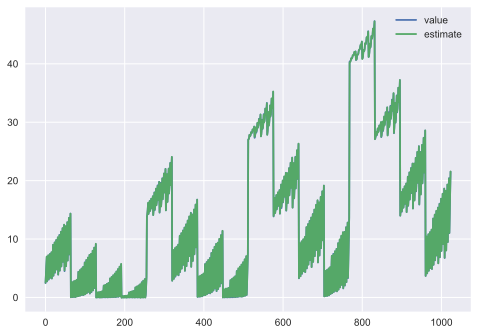

In [27]:
data[['value', 'estimate']].plot();

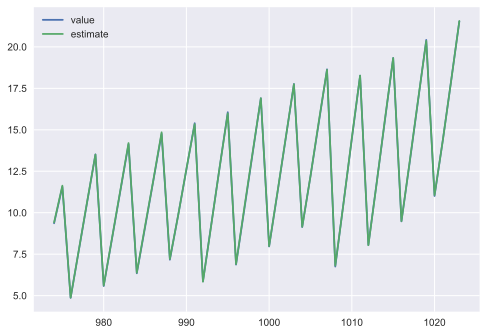

In [28]:
data[['value', 'estimate']].iloc[-50:].plot();

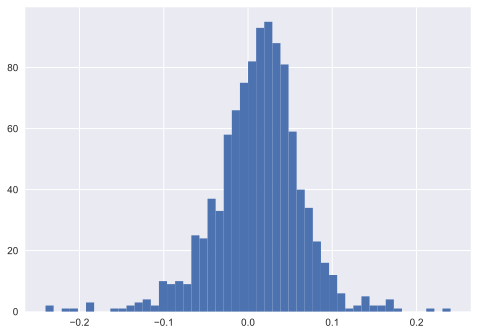

In [29]:
(data['estimate'] - data['value']).hist(bins=50);

### `TensorFlow/Keras`

In [30]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [31]:
import tensorflow as tf

In [32]:
tf.__version__

'2.11.1'

In [33]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

In [34]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(f)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

In [35]:
%time model.fit(data_[f], data['value'], epochs=1000, verbose=False)

CPU times: user 14.2 s, sys: 1.58 s, total: 15.8 s
Wall time: 12 s


In [36]:
data['estimate'] = model.predict(data_[f])

32/32 [==============================] - 0s 372us/step


In [37]:
data.head()

,S0,K,T,r,sigma,value,estimate
0,80.0,80.0,0.5,0.010000,0.100000,2.455784,2.447542
1,80.0,80.0,0.5,0.010000,0.166667,3.952585,3.972277
2,80.0,80.0,0.5,0.010000,0.233333,5.448590,5.433370
3,80.0,80.0,0.5,0.010000,0.300000,6.942116,6.946275
4,80.0,80.0,0.5,0.023333,0.100000,2.737608,2.708513


In [38]:
mean_squared_error(data['value'], data['estimate'])

0.001168175825584074

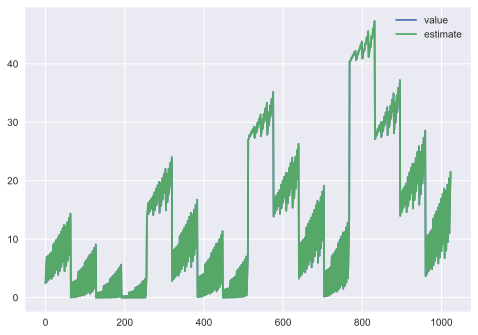

In [39]:
data[['value', 'estimate']].plot();

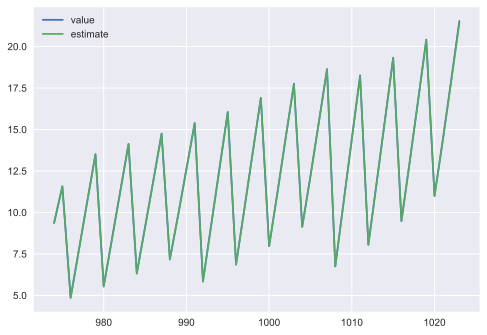

In [40]:
data[['value', 'estimate']].iloc[-50:].plot();

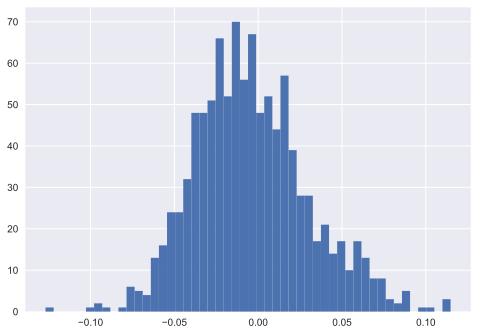

In [41]:
(data['estimate'] - data['value']).hist(bins=50);

### Generalization

In [42]:
d = pd.DataFrame(np.array((
            (80.0,	80.0, 0.5, 0.01, 0.1),  # in-sample
            (102.5, 107.5, 0.8, 0.015, 0.25),  # out-of-sample
            (102.5, 107.5, 0.8, 0.0175, 0.15))),  # out-of-sample
                 index=['o1', 'o2', 'o3'])      

In [43]:
d

,0,1,2,3,4
o1,80.0,80.0,0.5,0.0100,0.10
o2,102.5,107.5,0.8,0.0150,0.25
o3,102.5,107.5,0.8,0.0175,0.15


In [44]:
d_ = (d - mu.iloc[:-1].values) / std.iloc[:-1].values

In [45]:
d_

,0,1,2,3,4
o1,-1.340986,-1.340986,-1.340986,-1.340986,-1.340986
o2,0.167623,0.502870,-0.536394,-1.005739,0.670493
o3,0.167623,0.502870,-0.536394,-0.838116,-0.670493


In [46]:
np.set_printoptions(suppress=True)

In [47]:
model.predict(d_)

1/1 [==============================] - 0s 21ms/step


array([[2.447542 ],
       [7.3802066],
       [3.8335867]], dtype=float32)

In [48]:
bsm_call_value(80, 80, 0.5, 0.01, 0.1)

2.4557844073815716

In [49]:
bsm_call_value(102.5, 107.5, 0.8, 0.015, 0.25)

7.548415267132441

In [50]:
bsm_call_value(102.5, 107.5, 0.8, 0.0175, 0.15)

3.997026434855229

## Credit Scoring

**Classification**

Data from [Kaggle](https://www.kaggle.com/datasets/prasy46/credit-score-prediction/). The following data sets are smaller subsets of the original ones.

### The Data

In [51]:
url_train = 'https://certificate.tpq.io/kaggle_credit_score_train.csv'

In [52]:
url_test = 'https://certificate.tpq.io/kaggle_credit_score_test.csv'

In [53]:
train = pd.read_csv(url_train, index_col=0)

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62815 entries, 0 to 79999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x001    62815 non-null  int64  
 1   x002    62815 non-null  float64
 2   x003    62815 non-null  float64
 3   x004    62815 non-null  float64
 4   x005    62815 non-null  float64
 5   x006    62815 non-null  int64  
 6   x007    62815 non-null  int64  
 7   x008    62815 non-null  int64  
 8   x009    62815 non-null  int64  
 9   x010    62815 non-null  int64  
 10  y       62815 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.8 MB


In [55]:
train.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,y
0,1084094,426.0,39.0,128.0,426.0,0,0,0,0,0,807
1,1287777,160.0,2.0,64.0,160.0,1,1,2,0,1,819
2,1483016,163.0,16.0,104.0,239.0,0,0,0,1,0,803
4,1342113,3.0,2.0,2.0,62.0,0,2,2,0,0,485
5,807817,112.0,112.0,112.0,187.0,1,0,0,0,0,665


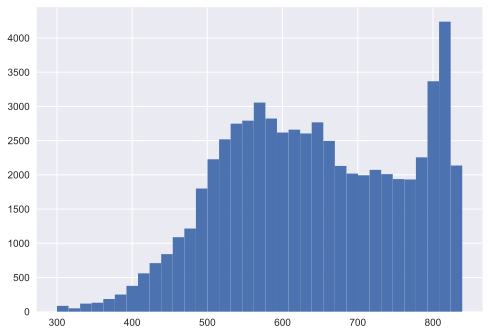

In [56]:
train.y.hist(bins=35);

In [57]:
r = {}
for i in range(300, 305):
    r[i] = i + 1

In [58]:
train['y'] = train['y'].replace(r)

In [59]:
train['y'] -= 301

In [60]:
list(set(train['y']))[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [61]:
train_ = (train - train.mean()) / train.std()

### Decision Trees

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [63]:
# DTC = DecisionTreeClassifier(max_depth=25)

In [64]:
# model = AdaBoostClassifier(estimator=DTC, n_estimators=5)

In [65]:
model = DecisionTreeClassifier(max_depth=35)

In [66]:
%time model.fit(train_.iloc[:, :-1], train['y']) 

CPU times: user 2.87 s, sys: 86.6 ms, total: 2.96 s
Wall time: 3 s


DecisionTreeClassifier(max_depth=35)

In [67]:
%time train['p'] = model.predict(train_.iloc[:, :-1])

CPU times: user 65.9 ms, sys: 55.3 ms, total: 121 ms
Wall time: 126 ms


In [68]:
accuracy_score(train['y'], train['p'])

0.9572713523839848

In [69]:
train['p'].value_counts()

p
313    355
520    321
516    299
518    297
511    294
      ... 
7        1
35       1
23       1
11       1
16       1
Name: count, Length: 539, dtype: int64

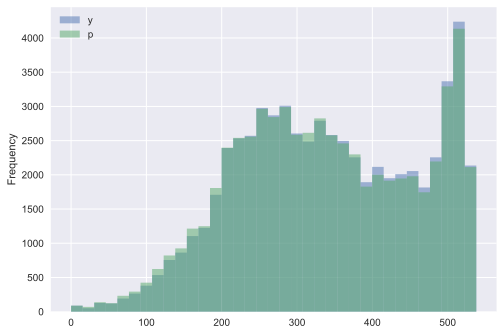

In [70]:
train[['y', 'p']].plot(kind='hist', bins=35, alpha=0.5);

### `TensorFlow/Keras`

In [71]:
train = pd.read_csv(url_train, index_col=0)

In [72]:
train['y'] = train['y'].replace(r)

In [73]:
train['y'] -= 301

In [74]:
n_features = len(train.columns) - 1
n_features

10

In [75]:
n_labels = len(set(train['y'])) + 1
n_labels

540

In [76]:
train_ = (train - train.mean()) / train.std()

In [77]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(train.columns) - 1))
model.add(Dense(128, activation='relu'))
model.add(Dense(n_labels, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [78]:
%%time
model.fit(train_.iloc[:, :-1], train['y'],
          epochs=250, batch_size=128, verbose=False)

CPU times: user 5min 39s, sys: 1min 34s, total: 7min 13s
Wall time: 3min 39s


In [79]:
train['p'] = np.argmax(model.predict(train_.iloc[:, :-1]), axis=1)

1963/1963 [==============================] - 1s 396us/step


In [80]:
accuracy_score(train['y'], train['p'])

0.07996497651834752

In [81]:
train.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,y,p
0,1084094,426.0,39.0,128.0,426.0,0,0,0,0,0,506,528
1,1287777,160.0,2.0,64.0,160.0,1,1,2,0,1,518,306
2,1483016,163.0,16.0,104.0,239.0,0,0,0,1,0,502,502
4,1342113,3.0,2.0,2.0,62.0,0,2,2,0,0,184,83
5,807817,112.0,112.0,112.0,187.0,1,0,0,0,0,364,342


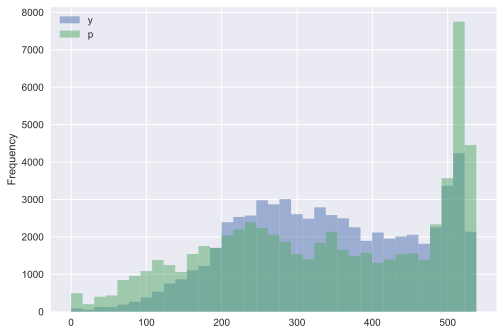

In [82]:
train[['y', 'p']].plot(kind='hist', bins=35, alpha=0.5);

<img src='http://hilpisch.com/tpq_logo.png' width="35%" align="right">

<br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">ai@tpq.io</a>